## Policy learning and Policy Gradients

This is a recap of policy learning contextualizes how we can use MJX's differentiability for policy learning. If the below concepts are unfamiliar, there are many great resources [online](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html)!  

The goal of policy learning is to find a control policy $\pi$ which outputs actions $a_t \sim \pi(\cdot| x_t, \theta)$ maximizing the total rewards $\sum r_t$ over some time period, where $r_t$ is shorthand for a reward function evaluated at the state and action of time t:

$$r_t = r(x_t, a_t)$$

$\theta$ are the parameters of the policy; weights in the common case that the policy is a neural network. **Policy gradient methods** involve estimating the gradient of the rewards with respect to the weights, and using this value in a first-order optimization algorithm such as Gradient Descent or [Adam](https://arxiv.org/abs/1412.6980). How we estimate the policy gradient depends on what state transition model we assume. 

#### Zeroth-Order Policy Gradients (ZoPG)

Referring to `mjx.step` as the simulation function f, we borrow some [terminology](https://arxiv.org/abs/2202.00817) to differentiate between zeroth-order gradients, which only depend on values of f, and first-order gradients, which depend on its jacobian.

Reinforcement learning (RL) algorithms such as the standard [PPO](https://github.com/google/brax/blob/main/brax/training/agents/ppo/train.py) assume the stochastic state transition model $x_{t+1} \sim P(\cdot | x_t, a_t)$. This leads to a ZoPG of the form:

$$
\nabla_\theta J(\pi_\theta) = \mathbb{E}_{\tau \sim \pi_\theta}\left[ \sum \nabla_\theta \log\pi_\theta (a_t | s_t) R(\tau) \right]
$$

Where $R(\tau)$ is some function depending on the rollout $\tau = \{x_t, a_t\}_{t=0}^{T}$. Despite this method's popularity and extensive research into its refinement, a fundamental property is that the gradient has high variance. This allows the optimizer to thoroughly explore the space of policies, leading to the robust and often surprisingly good policies that have been achieved. However, the variance comes at the cost of requiring many samples $(x_t, a_t)$ to converge.

#### First-Order Policy Gradients (FoPG)
On the other hand, if you assume a deterministic state transition model $x_{t+1} = f(x_t, a_t)$, you end up with the first-order policy gradient. Other common names include Analytical Policy Gradients (APG) and Backpropogation through Time (BPTT). Unlike ZoPG methods, which model the state evolution as a probabilistic black box, the FoPG explicitly contains the jacobians of the simulation function f. For example, let's look at the gradient of the reward $r_t$, in the case that it only depends on state.
$$
\frac{\partial r_t}{\partial \theta} = \frac{\partial r_t}{\partial x_t}\frac{\partial x_t}{\partial \theta} 
$$

$$
\frac{\partial x_t}{\partial \theta} = \textcolor{Navy}{\frac{\partial f(x_{t-1}, a_{t-1})}{\partial x_{t-1}}}\frac{\partial x_{t-1}}{\partial \theta} + \textcolor{Navy}{\frac{\partial f(x_{t-1}, a_{t-1})}{\partial a_{t-1}}} \frac{\partial a_{t-1}}{\partial \theta}
$$

The navy-colored terms in the above expression are enabled by MJX's differentiability and are the key difference between FoPG's and ZoPG's. An important consideration is what these jacobians look like near contact points. To see why certain gradients within the jacobian can be pathological, imagine a hard sphere falling toward a block of marble. How does its velocity change with respect to distance ($\frac{\partial \dot{z}_t}{\partial z_t}$), the instant before it touches the ground? This is the case of an **uninformative gradient**, due to [hard contact](https://arxiv.org/html/2404.02887v1). Fortunately, the default contact settings in Mujoco are sufficiently [soft](https://mujoco.readthedocs.io/en/stable/computation/index.html#soft-contact-model) for learning via FoPG's. With soft contacts, the ground applies an increasing force on the ball as it penetrates it, unlike rigid contacts, which instantly provide enough force for deflection.

A helpful way to think about FoPG's is via the chain rule and computation graphs, as illustrated below for how $r_2$ influences the policy gradient, again for the case that the reward does not depend on action:

<img src="../doc/images/mjx/apg_diagram.png" alt="drawing" width="300"/>

Note that there three distinct gradient chains in this example. The red pathway considers how the immediately prior action affected the state. The blue path explains the name *Backpropogation through Time*, capturing how actions affect downstream rewards. The least intuitive may be the green chain, which shows how the reward depends on how actions depend on previous actions.Experience shows that blocking *any* of these three pathways via jax.lax.stop_grad can badly hinder policy learning. As the length of $x_t$ backbone increases, [gradient explosion](https://arxiv.org/abs/2111.05803) becomes a crucial consideration. In practice, this can be resolved via decaying downstream gradients or periodically truncating the gradient.

**The Sharp Bits of FoPG's**

While FoPG's have been shown to be very sample efficient, especially as the [dimension of the state space increases](https://arxiv.org/abs/2204.07137), one fundamental shortcoming is that due to the lower gradient variance, FoPG's also have less exploration power than ZoPG's and benefit from the practioner being more explicit in the problem formulation.

Additionally, discontinuous reward formulations are ubiquitious in RL, for instance, a large penalty when the robot falls. It can be significantly more [challenging](https://arxiv.org/abs/2403.14864) to design robust policies with FoPG's, since they cannot backprop through such penalties.

Last, despite the sample efficiency, FoPG methods can still struggle with wall-clock time. Because the gradients have low variance, they do not benefit significantly from massive parallelization of data collection - unlike [RL](https://arxiv.org/abs/2109.11978). Additionally, the policy gradient is typically calculated via autodifferentiation. This can be 3-5x slower than unrolling the simulation forward, and memory intensive, with memory requirements scaling with $O(m \cdot (m+n) \cdot T)$, where m and n are the state and control dimensions, $m \cdot (m+n)$ is the jacobian dimension, and T is the number of steps propogated through.

Note that with certain models, using autodifferentiation through mjx.step currently causes [nan gradients](https://github.com/google-deepmind/mujoco/issues/1517). For now, we address this issue by using double-precision floats, at the cost of doubling the memory requirements and training time.

---

**Coming Up**

In this tutorial, we demonstrate two ways to use FoPG's, using Brax's simple APG [algorithm](https://github.com/google/brax/tree/main/brax/training/agents/apg). This algorithm essentially uses FoPG's to perform live gradient descent on the policy, unrolling it for a short window, using the data to do a policy update, then continuing where it left off.

## Setup: Imports and installations

In [1]:
import os
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.75" 
%env XLA_PYTHON_CLIENT_PREALLOCATE=false

from datetime import datetime
import functools

# Math
import jax.numpy as jp
import numpy as np
import jax
from jax import config # Analytical gradients work much better with double precision.
config.update("jax_debug_nans", True)
config.update("jax_enable_x64", True)
config.update('jax_default_matmul_precision', jax.lax.Precision.HIGH)
from brax import math

# Sim
import mujoco
import mujoco.mjx as mjx

# Brax
from brax import envs
from brax.base import Motion, Transform
from brax.io import mjcf
from brax.envs.base import PipelineEnv, State
from brax.mjx.pipeline import _reformat_contact
from brax.training.acme import running_statistics
from brax.io import model

# Algorithms
from brax.training.agents.apg import train as apg
from brax.training.agents.apg import networks as apg_networks
from brax.training.agents.ppo import train as ppo

# Supporting
from etils import epath
import mediapy as media
import matplotlib.pyplot as plt
%matplotlib notebook
from ml_collections import config_dict
from typing import Any, Dict
import h5py
import pickle

env: XLA_PYTHON_CLIENT_PREALLOCATE=false


#### Rodent Env

""

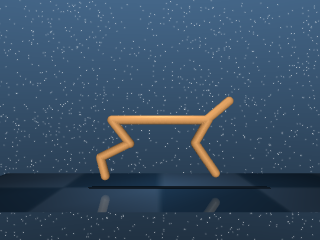

In [2]:
xml_path = "assets/cheetah.xml" # epath.Path('mujoco_menagerie/anybotics_anymal_c/scene_mjx.xml').as_posix()

mj_model = mujoco.MjModel.from_xml_path(xml_path)

if 'renderer' not in dir():
    renderer = mujoco.Renderer(mj_model)

# init_q = mj_model.keyframe('standing').qpos

mj_data = mujoco.MjData(mj_model)
# mj_data.qpos = init_q
mujoco.mj_forward(mj_model, mj_data)

renderer.update_scene(mj_data, camera=0)
media.show_image(renderer.render())

In [15]:
# Rendering Rollouts
def render_rollout(reset_fn, step_fn, 
                   inference_fn, env, 
                   n_steps = 1000, camera=None,
                   seed=0):
    rng = jax.random.key(seed)
    render_every = 3
    state = reset_fn(rng)
    rollout = [state.pipeline_state]

    for i in range(n_steps):
        act_rng, rng = jax.random.split(rng)
        ctrl, _ = inference_fn(state.obs, act_rng)
        state = step_fn(state, ctrl)
        if i % render_every == 0:
            rollout.append(state.pipeline_state)

    media.show_video(env.render(rollout, camera=camera), 
                     fps=1.0 / (env.dt*render_every),
                     codec='h264')

## Study 1: Imitating Kinematics

FoPG's have been demonstrated to work well in [imitation learning](https://openreview.net/forum?id=06mk-epSwZ), especially when the agent state is reset to track the reference state when it gets too far. In this section, we learn to trot in place. Due to the limited gain on the PD controllers, trotting quickly is far from trivial!

The RL environment has three rewards:
- min_reference_tracking penalizes error from the reference motion, in minimal coordinates. This makes the policy's output more precise.
- reference_tracking penalizes error in maximal coordinates and increases training stability.
- feet_height nudges the balance of which body positions and velocities to track, by placing additional incentive on the *position* of the feet.

#### The RL Environment

In [4]:
def get_config():
  def get_default_rewards_config():
    default_config = config_dict.ConfigDict(
        dict(
            scales=config_dict.ConfigDict(
              dict(
                min_reference_tracking = -2.5 * 3e-3, # to equalize the magnitude
                reference_tracking = -1.0,
                # feet_height = -1.0
                )
              )
            )
    )
    return default_config

  default_config = config_dict.ConfigDict(
      dict(rewards=get_default_rewards_config(),))

  return default_config

# Math functions from (https://github.com/jiawei-ren/diffmimic)
def quaternion_to_matrix(quaternions):
    r, i, j, k = quaternions[..., 0], quaternions[..., 1], quaternions[..., 2], quaternions[..., 3]
    two_s = 2.0 / (quaternions * quaternions).sum(-1)

    o = jp.stack(
        (
            1 - two_s * (j * j + k * k),
            two_s * (i * j - k * r),
            two_s * (i * k + j * r),
            two_s * (i * j + k * r),
            1 - two_s * (i * i + k * k),
            two_s * (j * k - i * r),
            two_s * (i * k - j * r),
            two_s * (j * k + i * r),
            1 - two_s * (i * i + j * j),
        ),
        -1,
    )
    return o.reshape(quaternions.shape[:-1] + (3, 3))

def matrix_to_rotation_6d(matrix):
    batch_dim = matrix.shape[:-2]
    return matrix[..., :2, :].reshape(batch_dim + (6,))

def quaternion_to_rotation_6d(quaternion):
    return matrix_to_rotation_6d(quaternion_to_matrix(quaternion))

class Cheetah(PipelineEnv):

  def __init__(
      self,
      termination_height: float=0.25,
      **kwargs,
  ):
    # step_k = kwargs.pop('step_k', 25)

    physics_steps_per_control_step = 10
    kwargs['n_frames'] = kwargs.get(
        'n_frames', physics_steps_per_control_step)

    mj_model = mujoco.MjModel.from_xml_path(xml_path)
    # mj_model.opt.solver = mujoco.mjtSolver.mjSOL_CG
    # mj_model.opt.iterations = 2
    # mj_model.opt.ls_iterations = 3
    # mj_model.opt.jacobian = 0 # dense
    # kp = 230
    # mj_model.actuator_gainprm[:, 0] = kp
    # mj_model.actuator_biasprm[:, 1] = -kp

    sys = mjcf.load_model(mj_model)
    
    super().__init__(sys=sys, **kwargs)    
    
    self.termination_height = termination_height
    
    # self._init_q = mj_model.keyframe('standing').qpos
    
    self.err_threshold = 0.4 # diffmimic; value from paper.
    
    # self._default_ap_pose = mj_model.keyframe('standing').qpos[7:]
    self.reward_config = get_config()

    # self.action_loc = self._default_ap_pose
    # self.action_scale = jp.array([0.2, 0.8, 0.8] * 4)
    
    # self.feet_inds = jp.array([21,28,35,42]) # LF, RF, LH, RH
    data_path = "./cheetah_eval_dmc_charlie.h5"
    

    #### Imitation reference
    with h5py.File(data_path, "r") as f:
      d = f['iter_488']['episode_0']['physics']
      self.kinematic_ref_qpos =  jp.array(
        d["qpos"]
      )
      self.kinematic_ref_qvel =  jp.array(
        d["qvel"]
      )
     
    # Shorten clip

    # Can decrease jit time and training wall-clock time significantly.
    self.pipeline_step = jax.checkpoint(self.pipeline_step, 
      policy=jax.checkpoint_policies.dots_with_no_batch_dims_saveable)
    
  def reset(self, rng: jax.Array) -> State:
    # Deterministic init

    qpos = jp.array(self.kinematic_ref_qpos[0])
    qvel = jp.array(self.kinematic_ref_qvel[0])
    
    data = self.pipeline_init(qpos, qvel)

    # Position onto ground
    pen = jp.min(data.contact.dist)
    qpos = qpos.at[2].set(qpos[2] - pen)
    data = self.pipeline_init(qpos, qvel)

    state_info = {
        'rng': rng,
        'steps': 0.0,
        'reward_tuple': {
            'reference_tracking': 0.0,
            'min_reference_tracking': 0.0,
            # 'feet_height': 0.0
        },
        'last_action': jp.zeros(self.sys.nu), # from MJX tutorial.
        'kinematic_ref': jp.zeros(self.sys.nq),
    }

    x, xd = data.x, data.xd
    obs = self._get_obs(data.qpos, x, xd, state_info)
    reward, done = jp.zeros(2)
    metrics = {}
    for k in state_info['reward_tuple']:
      metrics[k] = state_info['reward_tuple'][k]
    state = State(data, obs, reward, done, metrics, state_info)
    return jax.lax.stop_gradient(state)
  
  def step(self, state: State, action: jax.Array) -> State:
    action = jp.clip(action, -1, 1) # Raw action

    # action = (action * self.action_scale) # + self.action_loc

    data = self.pipeline_step(state.pipeline_state, action)
    
    ref_qpos = self.kinematic_ref_qpos[jp.array(state.info['steps'], int)]
    ref_qvel = self.kinematic_ref_qvel[jp.array(state.info['steps'], int)]
    
    # Calculate maximal coordinates
    ref_data = data.replace(qpos=ref_qpos, qvel=ref_qvel)
    ref_data = mjx.forward(self.sys, ref_data)
    ref_x, ref_xd = ref_data.x, ref_data.xd

    state.info['kinematic_ref'] = ref_qpos

    # observation data
    x, xd = data.x, data.xd
    obs = self._get_obs(data.qpos, x, xd, state.info)

    # Terminate if flipped over or fallen down.
    done = 0.0
    done = jp.where(x.pos[0, 2] < self.termination_height, 1.0, done)
    up = jp.array([0.0, 0.0, 1.0])
    done = jp.where(jp.dot(math.rotate(up, x.rot[0]), up) < 0, 1.0, done)

    # reward
    reward_tuple = {
        'reference_tracking': (
          self._reward_reference_tracking(x, xd, ref_x, ref_xd)
          * self.reward_config.rewards.scales.reference_tracking
        ),
        'min_reference_tracking': (
          self._reward_min_reference_tracking(ref_qpos, ref_qvel, state)
          * self.reward_config.rewards.scales.min_reference_tracking
        ),
        # 'feet_height': (
        #   self._reward_feet_height(data.geom_xpos[self.feet_inds][:, 2]
        #                            ,ref_data.geom_xpos[self.feet_inds][:, 2])
        #   * self.reward_config.rewards.scales.feet_height
        # )
    }
    
    reward = sum(reward_tuple.values())

    # state management
    state.info['reward_tuple'] = reward_tuple
    state.info['last_action'] = action # used for observation. 

    for k in state.info['reward_tuple'].keys():
      state.metrics[k] = state.info['reward_tuple'][k]

    state = state.replace(
        pipeline_state=data, obs=obs, reward=reward,
        done=done)
    
    #### Reset state to reference if it gets too far
    error = (((x.pos - ref_x.pos) ** 2).sum(-1)**0.5).mean()
    to_reference = jp.where(error > self.err_threshold, 1.0, 0.0)

    to_reference = jp.array(to_reference, dtype=int) # keeps output types same as input. 
    ref_data = self.mjx_to_brax(ref_data)

    data = jax.tree_util.tree_map(lambda x, y: 
                                  jp.array((1-to_reference)*x + to_reference*y, x.dtype), data, ref_data)
    
    x, xd = data.x, data.xd # Data may have changed.
    obs = self._get_obs(data.qpos, x, xd, state.info)
    
    return state.replace(pipeline_state=data, obs=obs)
    
  def _get_obs(self, qpos: jax.Array, x: Transform, xd: Motion,
               state_info: Dict[str, Any]) -> jax.Array:

    inv_base_orientation = math.quat_inv(x.rot[0])
    local_rpyrate = math.rotate(xd.ang[0], inv_base_orientation)

    obs_list = []
    # yaw rate
    obs_list.append(jp.array([local_rpyrate[2]]) * 0.25)
    # projected gravity
    obs_list.append(
        math.rotate(jp.array([0.0, 0.0, -1.0]), inv_base_orientation))
    # motor angles
    # angles = qpos[7:19]
    # obs_list.append(angles - self._default_ap_pose)
    obs_list.append(qpos[7:])
    # last action
    obs_list.append(state_info['last_action'])
    # kinematic reference
    kin_ref = self.kinematic_ref_qpos[jp.array(state_info['steps'], int)]
    obs_list.append(kin_ref[7:]) # First 7 indicies are fixed

    obs = jp.clip(jp.concatenate(obs_list), -100.0, 100.0)

    return obs
  
  def mjx_to_brax(self, data):
    """ 
    Apply the brax wrapper on the core MJX data structure.
    """
    q, qd = data.qpos, data.qvel
    x = Transform(pos=data.xpos[1:], rot=data.xquat[1:])
    cvel = Motion(vel=data.cvel[1:, 3:], ang=data.cvel[1:, :3])
    offset = data.xpos[1:, :] - data.subtree_com[self.sys.body_rootid[1:]]
    offset = Transform.create(pos=offset)
    xd = offset.vmap().do(cvel)
    data = _reformat_contact(self.sys, data)
    return data.replace(q=q, qd=qd, x=x, xd=xd)


  # ------------ reward functions----------------
  def _reward_reference_tracking(self, x, xd, ref_x, ref_xd):
    """
    Rewards based on inertial-frame body positions.
    Notably, we use a high-dimension representation of orientation.
    """

    f = lambda x, y: ((x - y) ** 2).sum(-1).mean()

    _mse_pos = f(x.pos,  ref_x.pos)
    _mse_rot = f(quaternion_to_rotation_6d(x.rot),
                 quaternion_to_rotation_6d(ref_x.rot))
    _mse_vel = f(xd.vel, ref_xd.vel)
    _mse_ang = f(xd.ang, ref_xd.ang)

    # Tuned to be about the same size.
    return _mse_pos      \
      + 0.1 * _mse_rot   \
      + 0.01 * _mse_vel  \
      + 0.001 * _mse_ang

  def _reward_min_reference_tracking(self, ref_qpos, ref_qvel, state):
    """ 
    Using minimal coordinates. Improves accuracy of joint angle tracking.
    """
    pos = jp.concatenate([
      state.pipeline_state.qpos[:3],
      state.pipeline_state.qpos[7:]])
    pos_targ = jp.concatenate([
      ref_qpos[:3],
      ref_qpos[7:]])
    pos_err = jp.linalg.norm(pos_targ - pos)
    vel_err = jp.linalg.norm(state.pipeline_state.qvel- ref_qvel)

    return pos_err + vel_err

  # def _reward_feet_height(self, feet_pos, feet_pos_ref):
    # return jp.sum(jp.abs(feet_pos - feet_pos_ref)) # try to drive it to 0 using the l1 norm.

envs.register_environment('cheetah', Cheetah)

#### Imitation Learning via FoPG's
Takes 15 minutes on a NVIDIA 3060 TI GPU

In [5]:
make_networks_factory = functools.partial(
    apg_networks.make_apg_networks,
    hidden_layer_sizes=(256, 128)
)

epochs = 300

train_fn = functools.partial(apg.train,
                             episode_length=1000,
                             policy_updates=epochs,
                             horizon_length=32,
                             num_envs=1024,
                             learning_rate=1e-4,
                             num_eval_envs=64,
                             num_evals=10 + 1,
                             use_float64=True,
                             normalize_observations=True,
                             network_factory=make_networks_factory)

In [6]:
# jax.disable_jit(disable=True)
x_data = []
y_data = []
ydataerr = []
times = [datetime.now()]

def progress(it, metrics):
  print(metrics['eval/episode_reward'])
  times.append(datetime.now())
  x_data.append(it)
  y_data.append(metrics['eval/episode_reward'])
  ydataerr.append(metrics['eval/episode_reward_std'])
  plt.errorbar(x_data, y_data, yerr=ydataerr)
  plt.show()
  
env = envs.get_environment("cheetah")
eval_env = envs.get_environment("cheetah")

make_inference_fn, params, _= train_fn(environment=env,
                                       progress_fn=progress,
                                       eval_env=eval_env)

plt.errorbar(x_data, y_data, yerr=ydataerr)

2024-05-22 19:02:59.239268: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.3 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


-303.07298780679776


<IPython.core.display.Javascript object>

-295.32931685407664
-281.38202577009235
-268.8981828855797
-271.78593582784083
-266.1390464197458
-268.8338419467482
-261.0164184607362
-261.58777173991973
-257.74534114426774
-260.2573719587584


<ErrorbarContainer object of 3 artists>

In [16]:
demo_env = envs.training.EpisodeWrapper(env, 
                                        episode_length=1000, 
                                        action_repeat=1)

render_rollout(
  jax.jit(demo_env.reset),
  jax.jit(demo_env.step),
  jax.jit(make_inference_fn(params)),
  demo_env,
  n_steps=1000,
  seed=1
)

model_path = './tmp/cheetah_run'
model.save_params(model_path, params)

FileNotFoundError: [Errno 2] No such file or directory: 'tmp/cheetah_run'

In [12]:
plt.plot(x_data, y_data)
plt.show()

<IPython.core.display.Javascript object>

**A note on sample efficiency**

Above, we train using epochs * horizon_length * num_envs = 1.024e6 total simulator steps. Let's see what we get from PPO, using ten times more samples:

In [8]:
train_fn = functools.partial(
    ppo.train, num_timesteps=10_000_000, num_evals=10, reward_scaling=0.1,
    episode_length=1000, normalize_observations=True, action_repeat=1,
    unroll_length=10, num_minibatches=32, num_updates_per_batch=8,
    discounting=0.97, learning_rate=3e-4, entropy_cost=1e-3, num_envs=1024,
    batch_size=1024, seed=0)

x_data = []
y_data = []
ydataerr = []
env = envs.get_environment("trotting_anymal", step_k = 13)

def progress(num_steps, metrics):
  x_data.append(num_steps)
  y_data.append(metrics['eval/episode_reward'])
  ydataerr.append(metrics['eval/episode_reward_std'])

make_inference_fn, params, _= train_fn(environment=env, progress_fn=progress)

plt.errorbar(x_data, y_data, yerr=ydataerr)
plt.xlabel('# environment steps')
plt.ylabel('reward per episode')

KeyError: 'trotting_anymal'

We see that PPO takes around 9e6 simulator steps to catch up to APG.

## Study 2: Quadruped Locomotion

As we saw in the imitation learning example, FoPG methods benefit from detailed reward signals. To teach locomotion, we reward the feet based on the Raibert Heuristic. Similarly to [prior work](https://arxiv.org/abs/2403.14864), we use a gait schedule to incentivize opposite pairs of legs to move in sync at a fixed frequency. At the beginning of a new scheduled step, we calculate the target position for the feet at the end of the step. 

For each foot, we calculate:

$$
p^* = h_0 + \frac{\Delta T}{2} v_0
$$

Where $p^*$ is x, y component of the foot's target position, $h_0$ is the x, y component of the corresponding hip at lift-off, $\Delta T$ is the scheduled step duration, and $v_0$ is the base velocity at lift-off. 

Due to their limited exploration power, FoPG methods benefit greatly from having an good "initial guess" of the policy - familiar terminology in Model Predictive Control and Trajectory Optimization. We formulate the problem as [residual learning](https://arxiv.org/abs/1512.03385). Let $\phi$ be the parameters of a baseline policy that we already have, and let $f$ and $g$ be the neural networks for the learned and baseline policy. We freeze $\phi$ and learn parameters $\theta$, for the policy:

$$
a_t = f(g(x_t; \phi), x_t; \theta) + g(x_t; \phi)
$$

We use the in-place trotting policy from last section as $\phi$ and $x_t$ denotes the state at time t. In this example we track a 0.75 m/s velocity target, but since locomotion is stabler at faster trots, you can experiment with $\phi$ for faster velocity targets!

While it might seem more natural to "hotstart" the learning by simply initializing the parameters $\theta$ as $\phi$, with the policy $a_t = f(x_t; \theta)$, we find that the residual method trains more stably in practice.

#### The RL Environment

In [ ]:
def axis_angle_to_quaternion(v: jp.ndarray, theta:jp.float_):
    """ 
    axis angle representation: rotation of theta around v. 
    """    
    return jp.concatenate([jp.cos(0.5*theta).reshape(1), jp.sin(0.5*theta)*v.reshape(3)])

def get_config():
  """Returns reward config for anymal quadruped environment."""

  def get_default_rewards_config():
    default_config = config_dict.ConfigDict(
        dict(
            scales=config_dict.ConfigDict(
                dict(
                    tracking_lin_vel = 1.0,
                    orientation = -1.0, # non-flat base
                    height = 0.5,
                    lin_vel_z=-1.0, # prevents the suicide policy
                    torque = -0.01,
                    feet_pos = -1, # Bad action hard-coding. 
                    feet_height = -1, # prevents it from just standing still
                    joint_velocity = -0.001
                    )
            ),
        )
    )
    return default_config

  default_config = config_dict.ConfigDict(
      dict(rewards=get_default_rewards_config(),))

  return default_config

class FwdTrotAnymal(PipelineEnv):

  def __init__(
      self,
      termination_height: float=0.25,
      **kwargs,
  ):
    
    self.target_vel = kwargs.pop('target_vel', 0.75)
    step_k = kwargs.pop('step_k', 25)
    self.baseline_inference_fn = kwargs.pop("baseline_inference_fn")
    physics_steps_per_control_step = 10
    kwargs['n_frames'] = kwargs.get(
        'n_frames', physics_steps_per_control_step)
    self.termination_height = termination_height

    mj_model = mujoco.MjModel.from_xml_path(xml_path)
    kp = 230
    mj_model.actuator_gainprm[:, 0] = kp
    mj_model.actuator_biasprm[:, 1] = -kp
    self._init_q = mj_model.keyframe('standing').qpos
    self._default_ap_pose = mj_model.keyframe('standing').qpos[7:]
    self.reward_config = get_config()

    self.action_loc = self._default_ap_pose
    self.action_scale = jp.array([0.2, 0.8, 0.8] * 4)
    
    self.target_h = self._init_q[2]

    sys = mjcf.load_model(mj_model)
    super().__init__(sys=sys, **kwargs)
    
    """
    Kinematic references are used for gait scheduling.
    """

    kinematic_ref_qpos = make_kinematic_ref(
      cos_wave, step_k, scale=0.3, dt=self.dt)
    self.l_cycle = jp.array(kinematic_ref_qpos.shape[0])
    self.kinematic_ref_qpos = jp.array(kinematic_ref_qpos + self._default_ap_pose)

    """
    Foot tracking
    """
    gait_k = step_k * 2
    self.gait_period = gait_k * self.dt

    self.step_k = step_k
    self.feet_inds = jp.array([21,28,35,42]) # LF, RF, LH, RH
    self.hip_inds = self.feet_inds - 6

    self.pipeline_step = jax.checkpoint(self.pipeline_step,
      policy=jax.checkpoint_policies.dots_with_no_batch_dims_saveable)
    
  def reset(self, rng: jax.Array) -> State:
    rng, key_xyz, key_ang, key_ax, key_q, key_qd = jax.random.split(rng, 6)

    qpos = jp.array(self._init_q)
    qvel = jp.zeros(18)
    
    #### Add Randomness ####
  
    r_xyz = 0.2 * (jax.random.uniform(key_xyz, (3,))-0.5)
    r_angle = (jp.pi/12) * (jax.random.uniform(key_ang, (1,)) - 0.5) # 15 deg range
    r_axis = (jax.random.uniform(key_ax, (3,)) - 0.5)
    r_axis = r_axis / jp.linalg.norm(r_axis)
    r_quat = axis_angle_to_quaternion(r_axis, r_angle)

    r_joint_q = 0.2 * (jax.random.uniform(key_q, (12,)) - 0.5)
    r_joint_qd = 0.1 * (jax.random.uniform(key_qd, (12,)) - 0.5)
  
    qpos = qpos.at[0:3].set(qpos[0:3] + r_xyz)
    qpos = qpos.at[3:7].set(r_quat)
    qpos = qpos.at[7:19].set(qpos[7:19] + r_joint_q)
    qvel = qvel.at[6:18].set(qvel[6:18] + r_joint_qd)
    
    data = self.pipeline_init(qpos, qvel)

    # Ensure you're not sunken into the ground nor above it.
    pen = jp.min(data.contact.dist)
    qpos = qpos.at[2].set(qpos[2] - pen)
    data = self.pipeline_init(qpos, qvel)

    state_info = {
        'rng': rng,
        'steps': 0.0,
        'reward_tuple': {
            'tracking_lin_vel': 0.0,
            'orientation': 0.0,
            'height': 0.0,
            'lin_vel_z': 0.0,
            'torque': 0.0,
            'joint_velocity': 0.0,
            'feet_pos': 0.0,
            'feet_height': 0.0
        },
        'last_action': jp.zeros(12), # from MJX tutorial.
        'baseline_action': jp.zeros(12),
        'xy0': jp.zeros((4, 2)),
        'k0': 0.0,
        'xy*': jp.zeros((4, 2))
    }

    x, xd = data.x, data.xd
    _obs = self._get_obs(data.qpos, x, xd, state_info) # inner obs; to trotter
  
    action_key, key = jax.random.split(state_info['rng'])
    state_info['rng'] = key
    next_action, _ = self.baseline_inference_fn(_obs, action_key)

    obs = jp.concatenate([_obs, next_action])

    reward, done = jp.zeros(2)
    metrics = {}
    for k in state_info['reward_tuple']:
      metrics[k] = state_info['reward_tuple'][k]
    state = State(data, obs, reward, done, metrics, state_info)
    return jax.lax.stop_gradient(state)

  def step(self, state: State, action: jax.Array) -> State:

    action = jp.clip(action, -1, 1)

    cur_base = state.obs[-12:]
    action += cur_base
    state.info['baseline_action'] = cur_base

    action = self.action_loc + (action * self.action_scale)

    data = self.pipeline_step(state.pipeline_state, action)
    
    # observation data
    x, xd = data.x, data.xd
    obs = self._get_obs(data.qpos, x, xd, state.info)

    # Terminate if flipped over or fallen down.
    done = 0.0
    done = jp.where(x.pos[0, 2] < self.termination_height, 1.0, done)
    up = jp.array([0.0, 0.0, 1.0])
    done = jp.where(jp.dot(math.rotate(up, x.rot[0]), up) < 0, 1.0, done)

    #### Foot Position Reference Updating ####

    # Detect the start of a new step
    s = state.info['steps']
    step_num = s // (self.step_k)
    even_step = step_num % 2 == 0
    new_step = (s % self.step_k) == 0
    new_even_step = jp.logical_and(new_step, even_step)
    new_odd_step = jp.logical_and(new_step, jp.logical_not(even_step))

    # Apply railbert heuristic to calculate target foot position, after step
    hip_xy = data.geom_xpos[self.hip_inds][:,:2] # 4 x 2
    v_body = data.qvel[0:2]
    step_period = self.gait_period/2
    raibert_xy = hip_xy + (step_period/2) * v_body

    # Update. 
    cur_tars = state.info['xy*']
    i_RFLH = jp.array([1, 2])
    i_LFRH = jp.array([0, 3])
    feet_xy = data.geom_xpos[self.feet_inds][:,:2]
    
    # With the trotting gait, we will move one pair of opposite legs, 
    # and keep the other pair fixed in place.
    case_c1 = raibert_xy.at[i_LFRH].set(feet_xy[i_LFRH]) 
    case_c2 = raibert_xy.at[i_RFLH].set(feet_xy[i_RFLH])
    xy_tars = jp.where(new_even_step, case_c1, cur_tars)
    xy_tars = jp.where(new_odd_step, case_c2, xy_tars)
    state.info['xy*'] = xy_tars

    # Save timestep and location at start of step.
    state.info['k0'] = jp.where(new_step,
                                state.info['steps'],
                                state.info['k0'])
    state.info['xy0'] = jp.where(new_step, 
                                 feet_xy,
                                 state.info['xy0'])

    # reward
    reward_tuple = {
        'tracking_lin_vel': (
            self._reward_tracking_lin_vel(jp.array([self.target_vel, 0, 0]), x, xd)
            * self.reward_config.rewards.scales.tracking_lin_vel
        ),
        'orientation': (
          self._reward_orientation(x)
          * self.reward_config.rewards.scales.orientation
        ),
        'lin_vel_z': (
            self._reward_lin_vel_z(xd)
            * self.reward_config.rewards.scales.lin_vel_z
        ),
        'height': (
          self._reward_height(data.qpos) 
          * self.reward_config.rewards.scales.height
        ),
        'torque': (
          self._reward_action(data.qfrc_actuator)
          * self.reward_config.rewards.scales.torque
        ),
        'joint_velocity': (
          self._reward_joint_velocity(data.qvel)
          * self.reward_config.rewards.scales.joint_velocity
        ),
        'feet_pos': (
          self._reward_feet_pos(data, state)
          * self.reward_config.rewards.scales.feet_pos
        ),
        'feet_height': (
          self._reward_feet_height(data, state.info)
          * self.reward_config.rewards.scales.feet_height
        )
    }
    
    reward = sum(reward_tuple.values())

    # state management
    state.info['reward_tuple'] = reward_tuple
    state.info['last_action'] = action

    for k in state.info['reward_tuple'].keys():
      state.metrics[k] = state.info['reward_tuple'][k]

    # next action
    action_key, key = jax.random.split(state.info['rng'])
    state.info['rng'] = key
    next_action, _ = self.baseline_inference_fn(obs, action_key)
    obs = jp.concatenate([obs, next_action])

    state = state.replace(
        pipeline_state=data, obs=obs, reward=reward,
        done=done)
    return state

  def _get_obs(self, qpos: jax.Array, x: Transform, xd: Motion,
               state_info: Dict[str, Any]) -> jax.Array:

    inv_base_orientation = math.quat_inv(x.rot[0])
    local_rpyrate = math.rotate(xd.ang[0], inv_base_orientation)

    obs_list = []
    # yaw rate
    obs_list.append(jp.array([local_rpyrate[2]]) * 0.25)
    # projected gravity
    obs_list.append(
        math.rotate(jp.array([0.0, 0.0, -1.0]), inv_base_orientation))
    # motor angles
    angles = qpos[7:19]
    obs_list.append(angles - self._default_ap_pose)
    # last action
    obs_list.append(state_info['last_action'])
    # gait schedule
    kin_ref = self.kinematic_ref_qpos[jp.array(state_info['steps']%self.l_cycle, int)]
    obs_list.append(kin_ref)

    obs = jp.clip(jp.concatenate(obs_list), -100.0, 100.0)

    return obs

  # ------------ reward functions----------------
  def _reward_tracking_lin_vel(
      self, commands: jax.Array, x: Transform, xd: Motion) -> jax.Array:
    # Tracking of linear velocity commands (xy axes)
    local_vel = math.rotate(xd.vel[0], math.quat_inv(x.rot[0]))
    lin_vel_error = jp.sum(jp.square(commands[:2] - local_vel[:2]))
    lin_vel_reward = jp.exp(-lin_vel_error)
    return lin_vel_reward
  def _reward_orientation(self, x: Transform) -> jax.Array:
    # Penalize non flat base orientation
    up = jp.array([0.0, 0.0, 1.0])
    rot_up = math.rotate(up, x.rot[0])
    return jp.sum(jp.square(rot_up[:2]))
  def _reward_lin_vel_z(self, xd: Motion) -> jax.Array:
    # Penalize z axis base linear velocity
    return jp.clip(jp.square(xd.vel[0, 2]), 0, 10)
  def _reward_joint_velocity(self, qvel):
      return jp.clip(jp.sqrt(jp.sum(jp.square(qvel[6:]))), 0, 100)
  def _reward_height(self, qpos) -> jax.Array:
    return jp.exp(-jp.abs(qpos[2] - self.target_h)) # Not going to be > 1 meter tall.
  def _reward_action(self, action) -> jax.Array:
    return jp.sqrt(jp.sum(jp.square(action)))
  def _reward_feet_pos(self, data, state):        
    dt = (state.info['steps'] - state.info['k0']) * self.dt # scalar
    step_period = self.gait_period / 2
    xyt = state.info['xy0'] + (state.info['xy*'] - state.info['xy0']) * (dt/step_period)

    feet_pos = data.geom_xpos[self.feet_inds][:, :2]

    rews = jp.sum(jp.square(feet_pos - xyt), axis=1)   
    rews = jp.clip(rews, 0, 10)
    return jp.sum(rews)
  def _reward_feet_height(self, data, state_info):
    """ 
    Feet height tracks rectified sine waves 
    """
    h_tar = 0.1
    t = state_info['steps'] * self.dt
    offset = self.gait_period/2
    ref1 = jp.sin((2*jp.pi/self.gait_period)*t) # RF and LH feet
    ref2 = jp.sin((2*jp.pi/self.gait_period)*(t - offset)) # LF and RH
    
    ref1, ref2 = ref1 * h_tar, ref2 * h_tar
    h_tars = jp.array([ref2, ref1, ref1, ref2])
    h_tars = h_tars.clip(min=0, max=None) + 0.02 # offset height of feet.
    
    feet_height = data.geom_xpos[self.feet_inds][:,2]
    errs = jp.clip(jp.square(feet_height - h_tars), 0, 10)
    return jp.sum(errs)
  
envs.register_environment('anymal', FwdTrotAnymal)


#### Residual Learning via FoPG's
Takes 15 minutes on a NVIDIA 3060 TI GPU

In [ ]:
# Reconstruct the trotting inference function
make_networks_factory = functools.partial(
    apg_networks.make_apg_networks,
    hidden_layer_sizes=(256, 128)
)

nets = make_networks_factory(observation_size=1, # Observation_size argument doesn't matter since it's only used for param init.
                             action_size=12,
                             preprocess_observations_fn=running_statistics.normalize)

make_inference_fn = apg_networks.make_inference_fn(nets)

# Configure locomotion training
make_networks_factory = functools.partial(
    apg_networks.make_apg_networks,
    hidden_layer_sizes=(128, 64)
)

epochs = 499

train_fn = functools.partial(apg.train,
                             episode_length=1000,
                             policy_updates=epochs,
                             horizon_length=32,
                             num_envs=64,
                             learning_rate=1.5e-4,
                             schedule_decay=0.995,
                             num_eval_envs=64,
                             num_evals=10 + 1,
                             use_float64=True,
                             normalize_observations=True,
                             network_factory=make_networks_factory)

model_path = '/tmp/trotting_2hz_policy'
params = model.load_params(model_path)
baseline_inference_fn = make_inference_fn(params)

env_kwargs = dict(target_vel=0.75, step_k=13, 
                  baseline_inference_fn=baseline_inference_fn)

<ErrorbarContainer object of 3 artists>

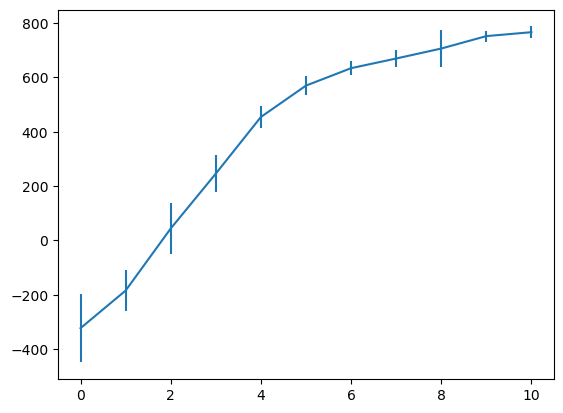

In [ ]:
x_data = []
y_data = []
ydataerr = []
times = [datetime.now()]

def progress(it, metrics):
  times.append(datetime.now())
  x_data.append(it)
  y_data.append(metrics['eval/episode_reward'])
  ydataerr.append(metrics['eval/episode_reward_std'])

env = envs.get_environment("anymal", **env_kwargs)
eval_env = envs.get_environment("anymal", **env_kwargs)

make_inference_fn, params, _= train_fn(environment=env,
                                       progress_fn=progress,
                                       eval_env=eval_env)

plt.errorbar(x_data, y_data, yerr=ydataerr)

""

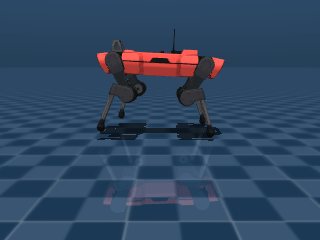

In [ ]:
demo_env = envs.training.EpisodeWrapper(env, 
                                        episode_length=1000, 
                                        action_repeat=1)

render_rollout(
  jax.jit(demo_env.reset),
  jax.jit(demo_env.step),
  jax.jit(make_inference_fn(params)),
  demo_env,
  n_steps=200,
  camera="track"
)

**A note on sample efficiency**

Let's compare with PPO, again using 1e7 samples:

Text(0, 0.5, 'reward per episode')

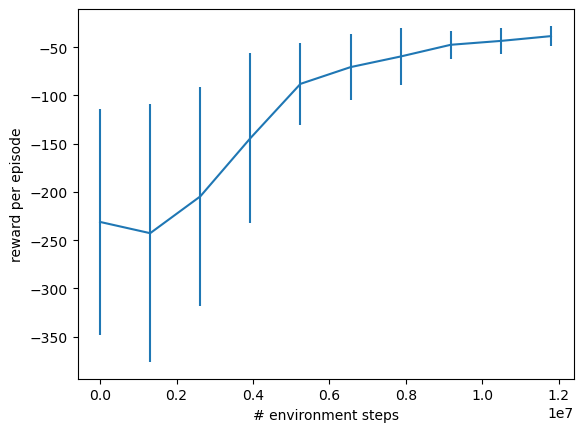

In [ ]:
train_fn = functools.partial(
    ppo.train, num_timesteps=10_000_000, num_evals=10, reward_scaling=0.1,
    episode_length=1000, normalize_observations=True, action_repeat=1,
    unroll_length=10, num_minibatches=32, num_updates_per_batch=8,
    discounting=0.97, learning_rate=3e-4, entropy_cost=1e-3, num_envs=1024,
    batch_size=1024, seed=0)

x_data = []
y_data = []
ydataerr = []

env = envs.get_environment("anymal", **env_kwargs)

def progress(num_steps, metrics):
  x_data.append(num_steps)
  y_data.append(metrics['eval/episode_reward'])
  ydataerr.append(metrics['eval/episode_reward_std'])

make_inference_fn, params, _= train_fn(environment=env, progress_fn=progress)

plt.errorbar(x_data, y_data, yerr=ydataerr)
plt.xlabel('# environment steps')
plt.ylabel('reward per episode')

We see that PPO struggles to learn locomotion in this setup, even with over 10x the number of simulator steps. 

Rather than indicating a shortcoming of PPO, this study demonstrates a policy-learning setup that effectively leverages FoPG methods. It involves learning small, accurate perturbations from a good baseline - optimizing to the local minima in a deep valley. FoPG's are precise enough to guide these perturbations using nuanced reward signals, such as our foot placement spline.

In contrast, RL algorithms such as PPO benefit from [policy-learning setups](https://colab.research.google.com/github/google-deepmind/mujoco/blob/main/mjx/tutorial.ipynb) that have less structured rewards. Unlike FoPG methods, they [benefit greatly](https://www.science.org/doi/abs/10.1126/scirobotics.adg1462) from sparse, non-differentiable rewards such as a large penalty for falling.